In [1]:
import numpy as np 
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/facial-expression-recognitionferchallenge/Submission.csv
/kaggle/input/facial-expression-recognitionferchallenge/fer2013/fer2013/README
/kaggle/input/facial-expression-recognitionferchallenge/fer2013/fer2013/fer2013.bib
/kaggle/input/facial-expression-recognitionferchallenge/fer2013/fer2013/fer2013.csv


In [2]:
import math
import numpy as np
import pandas as pd

import cv2
import scikitplot
import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.utils import np_utils

In [3]:
df = pd.read_csv('../input/facial-expression-recognitionferchallenge/fer2013/fer2013/fer2013.csv')
print(df.shape)
df.head()

(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [4]:
df.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1])

In [5]:
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

In [6]:
df.emotion.value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

In [7]:
math.sqrt(len(df.pixels[0].split(' ')))

48.0

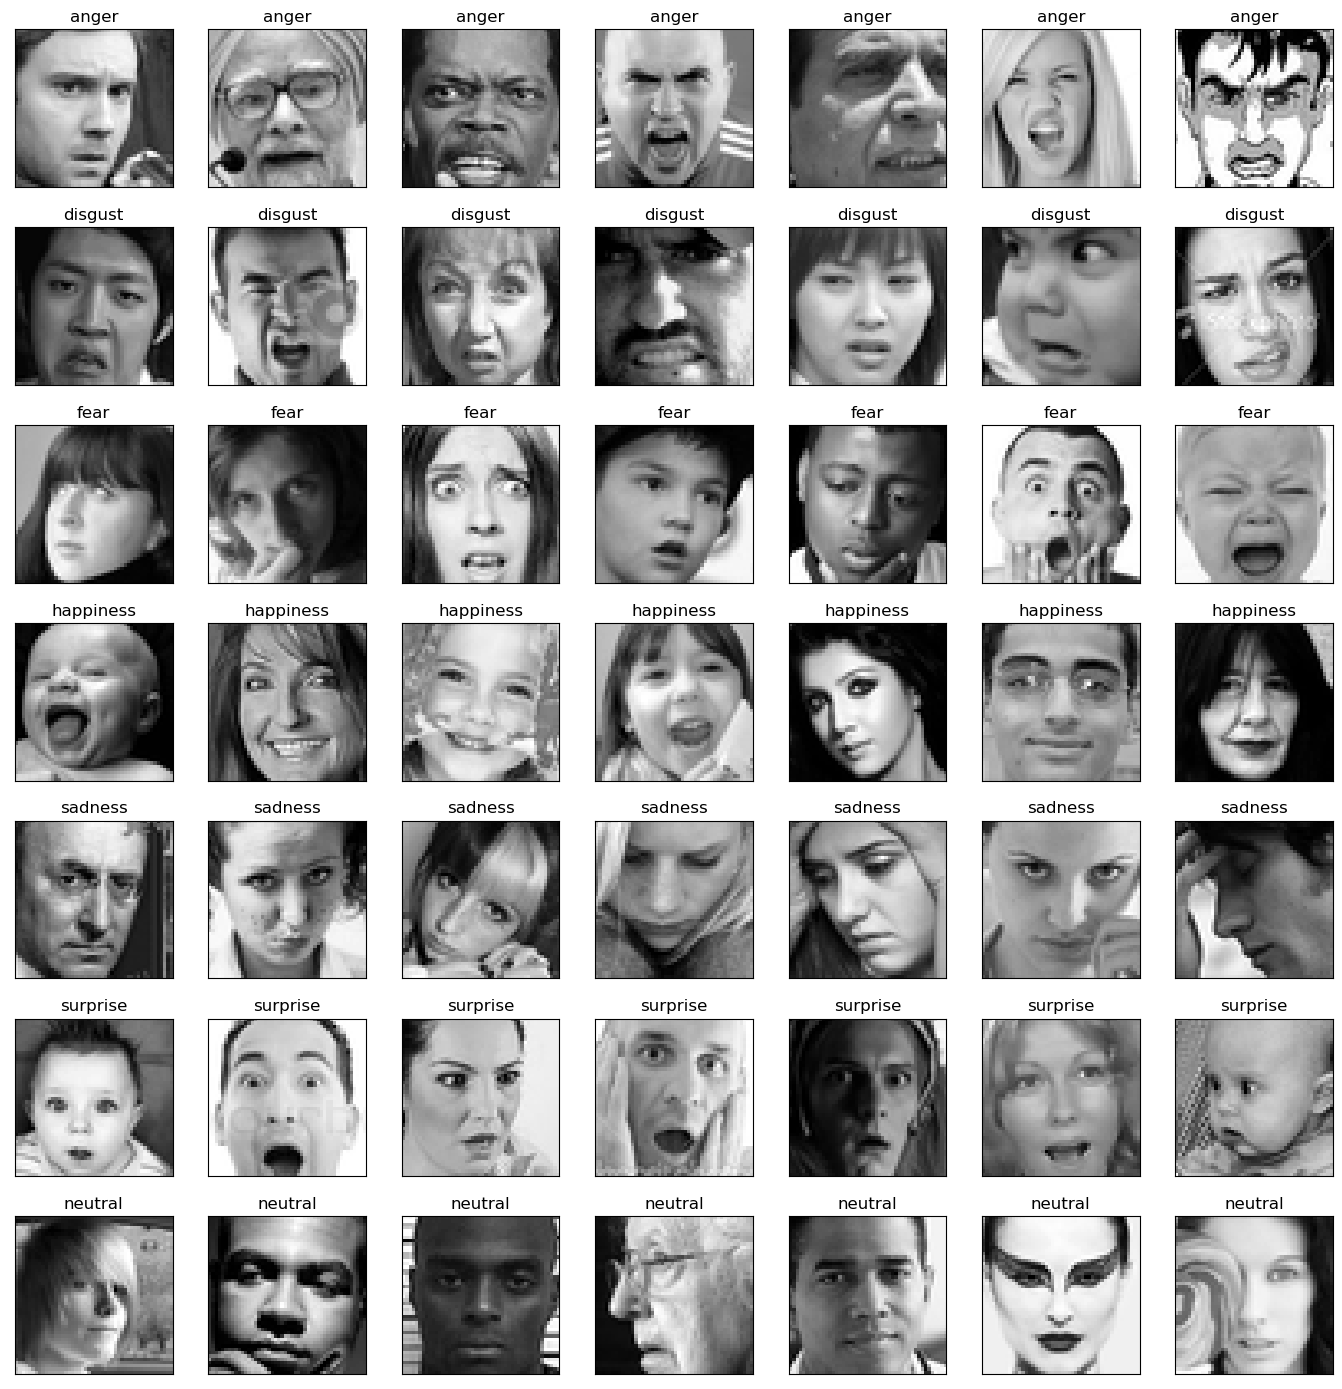

In [8]:
fig = pyplot.figure(1, (14, 14))

k = 0
for label in sorted(df.emotion.unique()):
    for j in range(7):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = pyplot.subplot(7, 7, k)
        ax.imshow(px, cmap = 'gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        pyplot.tight_layout()

In [9]:
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48).astype('float32'))
img_array = np.stack(img_array, axis = 0)

In [10]:
img_array.shape

(35887, 48, 48)

In [11]:
img_features = []

for i in range(len(img_array)):
    temp = cv2.cvtColor(img_array[i], cv2.COLOR_GRAY2RGB)
    img_features.append(temp)

img_features = np.array(img_features)
print(img_features.shape)

(35887, 48, 48, 3)


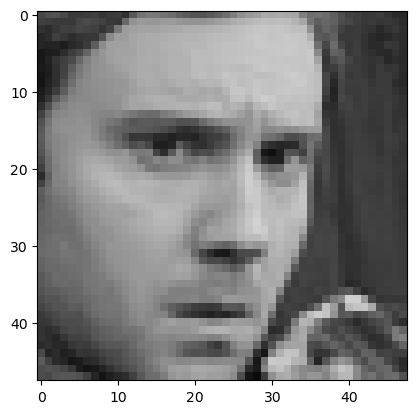

In [12]:
pyplot.imshow(img_features[0].astype(np.uint8));

In [13]:
le = LabelEncoder()

img_labels = le.fit_transform(df.emotion)
img_labels = np_utils.to_categorical(img_labels)
img_labels.shape

(35887, 7)

In [14]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}


In [15]:
X_train, X_valid, y_train, y_valid = train_test_split(img_features, 
                                                      img_labels, 
                                                      shuffle = True, 
                                                      stratify = img_labels, 
                                                      test_size = 0.1, 
                                                      random_state = 42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((32298, 48, 48, 3), (3589, 48, 48, 3), (32298, 7), (3589, 7))

In [16]:
del df
del img_features
del img_labels

In [17]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

In [18]:
X_train = X_train / 255.
X_valid = X_valid / 255.

In [19]:
vgg = tf.keras.applications.VGG16(weights = 'imagenet',
                                  include_top = False,
                                  input_shape = (48, 48, 3))

58889256/58889256 [==============================] - 1s 0us/step


In [20]:
# for layer in vgg.layers:
    # layer.trainable = False

In [21]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [22]:
def build_model(bottom_model, classes):
    model = bottom_model.layers[-2].output
    model = GlobalAveragePooling2D()(model)
    model = Dense(classes, activation = 'softmax', name = 'out_layer')(model)
    
    return model

In [23]:
head = build_model(vgg, num_classes)

model = Model(inputs = vgg.input, outputs = head)

print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [24]:
early_stopping = EarlyStopping(monitor = 'val_accuracy', 
                               min_delta = 0.00005, 
                               patience = 11,
                               verbose = 1, 
                               restore_best_weights = True,)

lr_scheduler = ReduceLROnPlateau(monitor = 'val_accuracy', 
                                 factor = 0.5, 
                                 patience = 7,
                                 min_lr = 1e-7,
                                 verbose = 1,)

callbacks = [early_stopping,lr_scheduler,]

### As the data in hand is less as compared to the task so ImageDataGenerator is good to go.

In [25]:
train_datagen = ImageDataGenerator(rotation_range = 15,
                                   width_shift_range = 0.15,
                                   height_shift_range = 0.15,
                                   shear_range = 0.15,
                                   zoom_range = 0.15,
                                   horizontal_flip = True,)
train_datagen.fit(X_train)

In [26]:
# batch size of 32 performs the best.
batch_size = 32 
epochs = 50
optims = [optimizers.Adam(learning_rate = 0.0001, beta_1 = 0.9, beta_2 = 0.999),]

model.compile(loss = 'categorical_crossentropy',
              optimizer = optims[0],
              metrics = ['accuracy'])

In [27]:
history = model.fit(train_datagen.flow(X_train, 
                                       y_train, 
                                       batch_size = batch_size),
                                       validation_data = (X_valid, y_valid),
                                       steps_per_epoch = len(X_train) / batch_size,
                                       epochs = epochs,
                                       callbacks = callbacks,
                                       use_multiprocessing = True)

Epoch 1/50
1009/1009 [==============================] - 51s 43ms/step - loss: 1.3880 - accuracy: 0.4657 - val_loss: 1.1759 - val_accuracy: 0.5528 - lr: 1.0000e-04
Epoch 2/50
1009/1009 [==============================] - 43s 42ms/step - loss: 1.1686 - accuracy: 0.5584 - val_loss: 1.0862 - val_accuracy: 0.5887 - lr: 1.0000e-04
Epoch 3/50
1009/1009 [==============================] - 43s 42ms/step - loss: 1.0809 - accuracy: 0.5920 - val_loss: 1.0342 - val_accuracy: 0.6113 - lr: 1.0000e-04
Epoch 4/50
1009/1009 [==============================] - 43s 42ms/step - loss: 1.0377 - accuracy: 0.6092 - val_loss: 0.9854 - val_accuracy: 0.6291 - lr: 1.0000e-04
Epoch 5/50
1009/1009 [==============================] - 43s 42ms/step - loss: 0.9902 - accuracy: 0.6304 - val_loss: 1.0221 - val_accuracy: 0.6149 - lr: 1.0000e-04
Epoch 6/50
1009/1009 [==============================] - 43s 42ms/step - loss: 0.9518 - accuracy: 0.6432 - val_loss: 0.9650 - val_accuracy: 0.6305 - lr: 1.0000e-04
Epoch 7/50
1009/1009 [

In [28]:
model_yaml = model.to_json()
with open("model.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
    
model.save("model.h5")

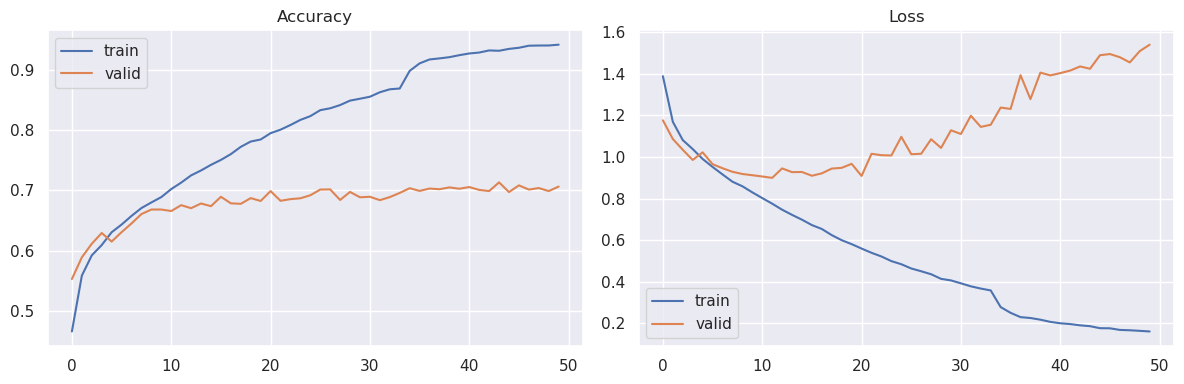

In [29]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('epoch_history_dcnn.png')
pyplot.show()


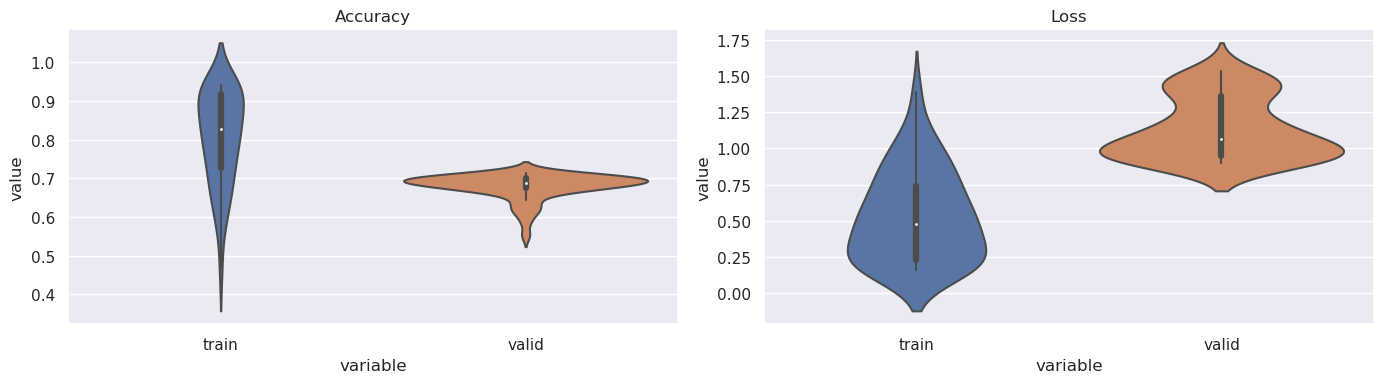

In [30]:
df_accu = pd.DataFrame({'train': history.history['accuracy'], 'valid': history.history['val_accuracy']})
df_loss = pd.DataFrame({'train': history.history['loss'], 'valid': history.history['val_loss']})

fig = pyplot.figure(0, (14, 4))
ax = pyplot.subplot(1, 2, 1)
sns.violinplot(x="variable", y="value", data=pd.melt(df_accu), showfliers=False)
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.violinplot(x="variable", y="value", data=pd.melt(df_loss), showfliers=False)
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('performance_dist.png')
pyplot.show()

113/113 [==============================] - 2s 13ms/step
total wrong validation predictions: 1054


              precision    recall  f1-score   support

           0       0.62      0.65      0.63       495
           1       0.82      0.60      0.69        55
           2       0.63      0.51      0.56       512
           3       0.91      0.85      0.88       899
           4       0.59      0.62      0.60       608
           5       0.82      0.80      0.81       400
           6       0.61      0.74      0.67       620

    accuracy                           0.71      3589
   macro avg       0.72      0.68      0.69      3589
weighted avg       0.71      0.71      0.71      3589



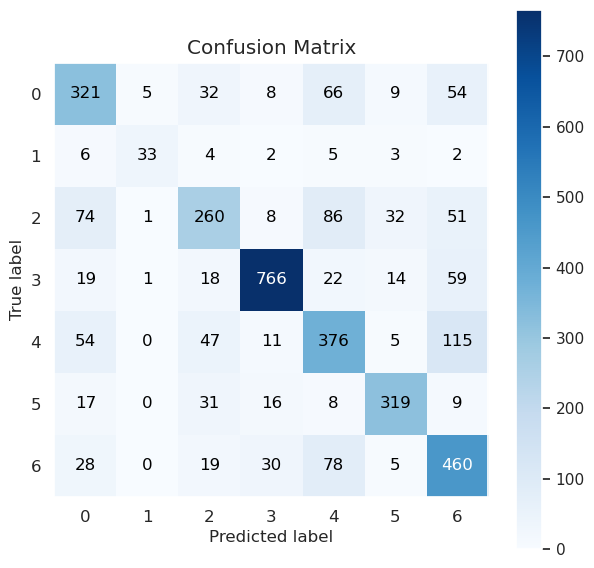

In [31]:
yhat_valid = np.argmax(model.predict(X_valid), axis=1)
scikitplot.metrics.plot_confusion_matrix(np.argmax(y_valid, axis=1), yhat_valid, figsize=(7,7))
pyplot.savefig("confusion_matrix_dcnn.png")

print(f'total wrong validation predictions: {np.sum(np.argmax(y_valid, axis=1) != yhat_valid)}\n\n')
print(classification_report(np.argmax(y_valid, axis=1), yhat_valid))

In [32]:
mapper = {
    0: 'anger',
    1: 'disgust',
    2: 'happiness',
    3: 'happiness',
    4: 'sadness',
    5: 'surprise',
    6: 'neutral'
}

1/1 [==============================] - 0s 22ms/step


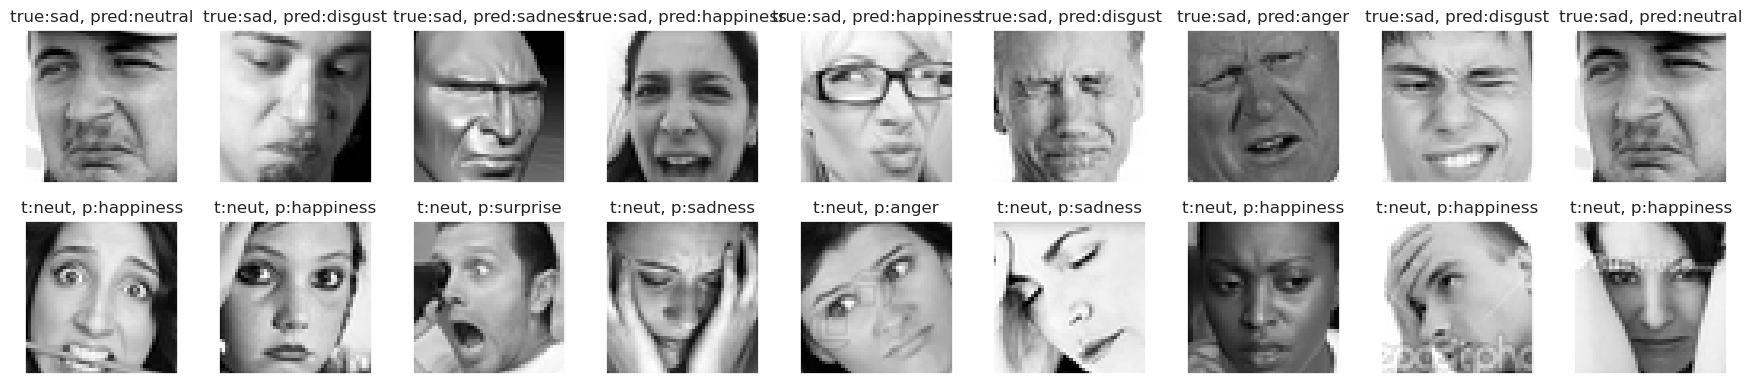

In [33]:
np.random.seed(2)
random_sad_imgs = np.random.choice(np.where(y_valid[:, 1]==1)[0], size=9)
random_neutral_imgs = np.random.choice(np.where(y_valid[:, 2]==1)[0], size=9)

fig = pyplot.figure(1, (18, 4))

for i, (sadidx, neuidx) in enumerate(zip(random_sad_imgs, random_neutral_imgs)):
    ax = pyplot.subplot(2, 9, i+1)
    sample_img = X_valid[sadidx,:,:,0]
    ax.imshow(sample_img, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    sample_img = cv2.cvtColor(sample_img, cv2.COLOR_GRAY2RGB)

    ax.set_title(f"true:sad, pred:{mapper[np.argmax(model.predict(sample_img.reshape(1,48,48,3))[0])]}")

    ax = pyplot.subplot(2, 9, i+10)
    sample_img = X_valid[neuidx,:,:,0]
    ax.imshow(sample_img, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    sample_img = cv2.cvtColor(sample_img, cv2.COLOR_GRAY2RGB)

    ax.set_title(f"t:neut, p:{mapper[np.argmax(model.predict(sample_img.reshape(1,48,48,3))[0])]}")

    pyplot.tight_layout()

In [44]:
model.save('my_model.h5')

In [35]:
new_model = tf.keras.models.load_model('my_model.keras')